# Human-Mammalian Brain Basal Ganglia 10X snRANSeq analysis: gene expression

[Intro text]

You need to be connected to the internet to run this notebook or connected to a cache that has the HMBA-BG data downloaded already.

The notebook presented here shows quick visualizations from precomputed metadata in the atlas. For examples on accessing the expression matrices, specifically selecting genes from expression matrices, see the ``general_acessing_10x_snRNASeq_tutorial.ipynb tutorial/example``.

In [1]:
from unittest.mock import patch

import pandas as pd
import numpy as np
import anndata
from pathlib import Path
import matplotlib.pyplot as plt

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache
from abc_atlas_access.abc_atlas_cache.anndata_utils import get_gene_data

We will interact with the data using the **AbcProjectCache**. This cache object tracks which data has been downloaded and serves the path to the requested data on disk. For metadata, the cache can also directly serve up a Pandas DataFrame. See the ``getting_started`` notebook for more details on using the cache including installing it if it has not already been. 

**Change the download_base variable to where you have downloaded the data in your system.**

In [2]:
test_data_base = Path('/allen/programs/celltypes/workgroups/rnaseqanalysis/lydian/hmba_bg_prep')

download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_cache_dir(download_base)

abc_cache.current_manifest

'releases/20250331/manifest.json'

Create the expanded cell metadata as was done previously in the cluster annotation tutorial of the 10X tutorials.

In [3]:
# Load the cell metadata.
cell = pd.read_csv(
    test_data_base / "HMBA-10xMultiome-BG/metadata/cell_metadata.csv",
    dtype={'cell_label': str}
).set_index('cell_label')
donor = pd.read_csv(
    test_data_base / "HMBA-10xMultiome-BG/metadata/donor.csv"
).set_index('donor_label')
library = pd.read_csv(
    test_data_base / "HMBA-10xMultiome-BG/metadata/library.csv"
).set_index('library_label')
value_sets = pd.read_csv(
    test_data_base / "extracted/value_sets.csv"
).set_index('label')

cell_extended = cell.join(donor, on='donor_label')
cell_extended = cell_extended.join(
    library, on='library_label',
    rsuffix='_library_table'
)

cell_extended['region_of_interest_label_color'] = value_sets[
    value_sets['table'] == 'library'
].loc[cell_extended['region_of_interest_label']]['color_hex_triplet'].values
cell_extended['region_of_interest_label_order'] = value_sets[
    value_sets['table'] == 'library'
].loc[cell_extended['region_of_interest_label']]['order'].values

cell_extended['species_scientific_name_color'] = value_sets[
    value_sets['table'] == 'donor'
].loc[cell_extended['species_scientific_name']]['color_hex_triplet'].values
cell_extended['species_scientific_name_order'] = value_sets[
    value_sets['table'] == 'donor'
].loc[cell_extended['species_scientific_name']]['order'].values

cell_extended['species_common_name_color'] = value_sets[
    value_sets['table'] == 'donor'
].loc[cell_extended['species_common_name']]['color_hex_triplet'].values
cell_extended['species_common_name_order'] = value_sets[
    value_sets['table'] == 'donor'
].loc[cell_extended['species_common_name']]['order'].values

cell_extended['donor_sex_color'] = value_sets[
    value_sets['table'] == 'donor'
].loc[cell_extended['donor_sex']]['color_hex_triplet'].values
cell_extended['donor_sex_order'] = value_sets[
    value_sets['table'] == 'donor'
].loc[cell_extended['donor_sex']]['order'].values

# Load the cluster memembership metadata and combine the data with the cell data.
cell_2d_embedding_coordinates = pd.read_csv(
    test_data_base / "HMBA-BG-taxonomy-CCN20250428/cell_2d_embedding_coordinates.csv"
).set_index('cell_label')
cell_extended = cell_extended.join(cell_2d_embedding_coordinates)

cell_to_cluster_membership = pd.read_csv(
    test_data_base / "HMBA-BG-taxonomy-CCN20250428/cell_to_cluster_membership.csv"
).set_index('cell_label')

cluster_to_cluster_annotation_membership = pd.read_csv(
    test_data_base / "HMBA-BG-taxonomy-CCN20250428/cluster_to_cluster_annotation_membership.csv"
).set_index('cluster_annotation_term_label')
cluster_annotation_term = pd.read_csv(
    test_data_base / "HMBA-BG-taxonomy-CCN20250428/cluster_annotation_term.csv"
).rename(columns={'label': 'cluster_annotation_term_label'}).set_index('cluster_annotation_term_label')
membership = cluster_to_cluster_annotation_membership.join(
    cluster_annotation_term,
    rsuffix='anno_term'
).reset_index()
membership_groupby = membership.groupby(
    ['cluster_alias', 'cluster_annotation_term_set_name']
)

cluster_annotation_term_set = pd.read_csv(
    test_data_base / "HMBA-BG-taxonomy-CCN20250428/cluster_annotation_term_set.csv"
)

# term_sets = abc_cache.get_metadata_dataframe(directory='WHB-taxonomy', file_name='cluster_annotation_term_set').set_index('label')
cluster_details = membership_groupby['cluster_annotation_term_name'].first().unstack()
cluster_order = membership_groupby['term_order'].first().unstack()
cluster_order.sort_values(['Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster'], inplace=True)
cluster_order.rename(
    columns={'Neighborhood': 'Neighborhood_order',
             'Class': 'Class_order',
             'Subclass': 'Subclass_order',
             'Group': 'Group_order',
             'Cluster': 'Cluster_order'},
    inplace=True
)

cluster_colors = membership_groupby['color_hex_triplet'].first().unstack()
cluster_colors = cluster_colors[cluster_annotation_term_set['name']]
cluster_colors.sort_values(
    ['Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster'],
    inplace=True
)

cell_extended = cell_extended.join(cell_to_cluster_membership)
cell_extended = cell_extended.join(cluster_details, on='cluster_alias')
cell_extended = cell_extended.join(cluster_colors, on='cluster_alias', rsuffix='_color')
cell_extended = cell_extended.join(cluster_order, on='cluster_alias')

cell_extended.head(5)

/tmp/ipykernel_29696/2421736158.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  cell = pd.read_csv(


cell_barcode donor_label  \
cell_label                                                
AAACAGCCAAATGCCC-2362_A05  AAACAGCCAAATGCCC  H24.30.001   
AAACAGCCAATTGAGA-2362_A05  AAACAGCCAATTGAGA  H24.30.001   
AAACAGCCAGCATGTC-2362_A05  AAACAGCCAGCATGTC  H24.30.001   
AAACAGCCATTGACAT-2362_A05  AAACAGCCATTGACAT  H24.30.001   
AAACAGCCATTGTGGC-2362_A05  AAACAGCCATTGTGGC  H24.30.001   

                          barcoded_cell_sample_label       library_label  \
cell_label                                                                 
AAACAGCCAAATGCCC-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCAATTGAGA-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCAGCATGTC-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCATTGACAT-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCATTGTGGC-2362_A05                   2362_A05  L8XR_240808_01_E02   

                                                   alignment_job_id  \
cell_label                                                            
AAACAGCCAAATGCCC-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCAATTGAGA-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCAGCATGTC-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCATTGACAT-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCATTGTGGC-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   

                           doublet_score  umi_count  \
cell_label                                            
AAACAGCCAAATGCCC-2362_A05       0.027027    15259.0   
AAACAGCCAATTGAGA-2362_A05       0.054795    20645.0   
AAACAGCCAGCATGTC-2362_A05       0.000000     2551.0   
AAACAGCCATTGACAT-2362_A05       0.000000     2341.0   
AAACAGCCATTGTGGC-2362_A05       0.027397     8326.0   

                                feature_matrix_label        dataset_label  \
cell_label                                                                  
AAACAGCCAAATGCCC-2362_A05  HMBA-10xMultiome-BG-Human  HMBA-10xMultiome-BG   
AAACAGCCAATTGAGA-2362_A05  HMBA-10xMultiome-BG-Human  HMBA-10xMultiome-BG   
AAACAGCCAGCATGTC-2362_A05  HMBA-10xMultiome-BG-Human  HMBA-10xMultiome-BG   
AAACAGCCATTGACAT-2362_A05  HMBA-10xMultiome-BG-Human  HMBA-10xMultiome-BG   
AAACAGCCATTGTGGC-2362_A05  HMBA-10xMultiome-BG-Human  HMBA-10xMultiome-BG   

                            donor_species  ... Neighborhood_color Class_color  \
cell_label                                 ...                                  
AAACAGCCAAATGCCC-2362_A05  NCBITaxon:9606  ...            #f2ca7d     #cba5ec   
AAACAGCCAATTGAGA-2362_A05  NCBITaxon:9606  ...            #f2ca7d     #8605d4   
AAACAGCCAGCATGTC-2362_A05  NCBITaxon:9606  ...            #f2ca7d     #aa6dec   
AAACAGCCATTGACAT-2362_A05  NCBITaxon:9606  ...            #f2ca7d     #8605d4   
AAACAGCCATTGTGGC-2362_A05  NCBITaxon:9606  ...            #f2ca7d     #6ec0da   

                          Subclass_color Group_color  Cluster_color  \
cell_label                                                            
AAACAGCCAAATGCCC-2362_A05        #226a65     #c3ec86        #d943f7   
AAACAGCCAATTGAGA-2362_A05        #def476     #488edc        #a9de1a   
AAACAGCCAGCATGTC-2362_A05        #761646     #cbfc1e        #475713   
AAACAGCCATTGACAT-2362_A05        #def476     #488edc        #a9de1a   
AAACAGCCATTGTGGC-2362_A05        #604f15     #e16c95        #238c7a   

                          Class_order Cluster_order Group_order  \
cell_label                                                        
AAACAGCCAAATGCCC-2362_A05         4.0         282.0        18.0   
AAACAGCCAATTGAGA-2362_A05         3.0         142.0        10.0   
AAACAGCCAGCATGTC-2362_A05         2.0          92.0         5.0   
AAACAGCCATTGACAT-2362_A05         3.0         142.0        10.0   
AAACAGCCATTGTGGC-2362_A05         1.0          34.0         2.0   

                          Neighborhood_order Subclass_order  
cell_label                                                   


### Single cell transcriptomes

The ~2 million cell dataset of HMBA-BG has been divided into expression matrices by species, one for each. Each matrix file is formatted as an annadata, h5ad file with minimal metadata.  

Below we show some interactions with data from the 10X expression matrices in the HMBA-BG dataset. For a deeper dive into how to access specific gene data from the expression matrices, take a look at ``general_acessing_10x_snRNASeq_tutorial.ipynb``.  

First, we list the available metadata in the HMBA-BG 10X dataset again. 

In [18]:
# abc_cache.list_metadata_files('HMBA-10xMultiome-BG')

We first load the gene data for the Macaqueportion of the dataset.

In [7]:
macaque_gene = pd.read_csv(test_data_base / 'chris_output/macaque_gene.csv')
macaque_gene.set_index('gene_identifier_with_chromosome', inplace=True)
print("Number of macaque genes = ", len(macaque_gene))
macaque_gene.head(5)

Number of macaque genes =  35219


gene_symbol     gene_identifier  \
gene_identifier_with_chromosome                                     
NCBIGene:114678393:NC_041754.1          PGBD2  NCBIGene:114678393   
NCBIGene:114674980:NC_041754.1   LOC114674980  NCBIGene:114674980   
NCBIGene:114675584:NC_041754.1      TRNAE-CUC  NCBIGene:114675584   
NCBIGene:710010:NC_041754.1            ZNF692     NCBIGene:710010   
NCBIGene:114675587:NC_041754.1      TRNAL-CAA  NCBIGene:114675587   

                                  chromosome  molecular_type  \
gene_identifier_with_chromosome                                
NCBIGene:114678393:NC_041754.1   NC_041754.1  protein-coding   
NCBIGene:114674980:NC_041754.1   NC_041754.1           snRNA   
NCBIGene:114675584:NC_041754.1   NC_041754.1            tRNA   
NCBIGene:710010:NC_041754.1      NC_041754.1  protein-coding   
NCBIGene:114675587:NC_041754.1   NC_041754.1            tRNA   

                                                                description  \
gene_identifier_with_chromosome                                               
NCBIGene:114678393:NC_041754.1      piggyBac transposable element derived 2   
NCBIGene:114674980:NC_041754.1                          U6 spliceosomal RNA   
NCBIGene:114675584:NC_041754.1   transfer RNA glutamic acid (anticodon CUC)   
NCBIGene:710010:NC_041754.1                         zinc finger protein 692   
NCBIGene:114675587:NC_041754.1         transfer RNA leucine (anticodon CAA)   

                                    ensembl_gene_identifier  \
gene_identifier_with_chromosome                               
NCBIGene:114678393:NC_041754.1   ENSEMBL:ENSMMUG00000023296   
NCBIGene:114674980:NC_041754.1   ENSEMBL:ENSMMUG00000036181   
NCBIGene:114675584:NC_041754.1                          NaN   
NCBIGene:710010:NC_041754.1      ENSEMBL:ENSMMUG00000000634   
NCBIGene:114675587:NC_041754.1                          NaN   

                                ensembl_gene_symbol      ensembl_description  
gene_identifier_with_chromosome                                               
NCBIGene:114678393:NC_041754.1                  NaN                      NaN  
NCBIGene:114674980:NC_041754.1                   U6      U6 spliceosomal RNA  
NCBIGene:114675584:NC_041754.1                  NaN                      NaN  
NCBIGene:710010:NC_041754.1                  ZNF692  zinc finger protein 692  
NCBIGene:114675587:NC_041754.1                  NaN                      NaN

Next Marmoset 

In [8]:
marmoset_gene = pd.read_csv(test_data_base / 'chris_output/marmoset_gene.csv')
marmoset_gene.set_index('gene_identifier', inplace=True)
print("Number of marmoset genes = ", len(marmoset_gene))
marmoset_gene.head(5)

Number of marmoset genes =  35787


gene_symbol  \
gene_identifier                    
NCBIGene:118152095  LOC118152095   
NCBIGene:118147983  LOC118147983   
NCBIGene:100395011  LOC100395011   
NCBIGene:118147921  LOC118147921   
NCBIGene:100385748  LOC100385748   

                                                        description  \
gene_identifier                                                       
NCBIGene:118152095         glucose-6-phosphate 1-dehydrogenase-like   
NCBIGene:118147983                              U6 spliceosomal RNA   
NCBIGene:100395011                            alpha-internexin-like   
NCBIGene:118147921                              U4 spliceosomal RNA   
NCBIGene:100385748  heterogeneous nuclear ribonucleoprotein A1-like   

                            molecular_type  
gene_identifier                             
NCBIGene:118152095  transcribed_pseudogene  
NCBIGene:118147983                   snRNA  
NCBIGene:100395011              pseudogene  
NCBIGene:118147921                   snRNA  
NCBIGene:100385748          protein_coding

Finally the Human genes.

In [9]:
human_gene = pd.read_csv(test_data_base / 'chris_output/human_gene.csv')
human_gene.set_index('gene_identifier', inplace=True)
print("Number of human genes = ", len(human_gene))
human_gene.head()

Number of human genes =  36601


gene_symbol chromosome  molecular_type  \
gene_identifier                                           
ENSG00000243485  MIR1302-2HG       chr1          lncRNA   
ENSG00000237613      FAM138A       chr1          lncRNA   
ENSG00000186092        OR4F5       chr1  protein_coding   
ENSG00000238009   AL627309.1       chr1          lncRNA   
ENSG00000239945   AL627309.3       chr1          lncRNA   

                                                      description  
gene_identifier                                                    
ENSG00000243485                               MIR1302-2 host gene  
ENSG00000237613      family with sequence similarity 138 member A  
ENSG00000186092  olfactory receptor family 4 subfamily F member 5  
ENSG00000238009                                  novel transcript  
ENSG00000239945                                  novel transcript

Now that we have our gene data, we can process each h5ad file in turn. First the Macaque data.

In [12]:
gene_names = ['SLC17A6', 'SLC17A7', 'SLC32A1', 'PTPRC', 'PLP1', 'AQP4', 'TTR']

with patch.object(
        abc_cache,
        'get_data_path',
        return_value=test_data_base / 'chris_output/HMBA-10xMultiome-BG-Macaque-log2.h5ad'
):
    print(abc_cache.get_data_path())
    macaque_gene_data = get_gene_data(
        abc_atlas_cache=abc_cache,
        all_cells=cell_extended[cell_extended['feature_matrix_label']=='HMBA-10xMultiome-BG-Macaque'],
        all_genes=macaque_gene,
        selected_genes=gene_names
    )

/allen/programs/celltypes/workgroups/rnaseqanalysis/lydian/hmba_bg_prep/chris_output/HMBA-10xMultiome-BG-Macaque-log2.h5ad
loading file: HMBA-10xMultiome-BG-Macaque
 - time taken:  243.76769872699998
total time taken: 243.768218423
	total cells: 839102 processed cells: 839102


Next the Marmoset.

In [13]:
gene_names = ['SLC17A6', 'SLC17A7', 'SLC32A1', 'PTPRC', 'PLP1', 'AQP4', 'TTR']

with patch.object(
        abc_cache,
        'get_data_path',
        return_value=test_data_base / 'chris_output/HMBA-10xMultiome-BG-Marmoset-log2.h5ad'
):
    print(abc_cache.get_data_path())
    marmoset_gene_data = get_gene_data(
        abc_atlas_cache=abc_cache,
        all_cells=cell_extended[cell_extended['feature_matrix_label']=='HMBA-10xMultiome-BG-Marmoset'],
        all_genes=marmoset_gene,
        selected_genes=gene_names
    )

/allen/programs/celltypes/workgroups/rnaseqanalysis/lydian/hmba_bg_prep/chris_output/HMBA-10xMultiome-BG-Marmoset-log2.h5ad
loading file: HMBA-10xMultiome-BG-Marmoset
 - time taken:  106.27976782100001
total time taken: 106.280343695
	total cells: 414575 processed cells: 414575


Finaly the Human data.

In [14]:
gene_names = ['SLC17A6', 'SLC17A7', 'SLC32A1', 'PTPRC', 'PLP1', 'AQP4', 'TTR']

# Note that as these data are not currently released, we can't load them through the AbcProjectCache.
# Below we patch in the location of the h5ad file we will use to allow us to use our get_gene_data function.
with patch.object(
        abc_cache,
        'get_data_path',
        return_value=test_data_base / 'chris_output/HMBA-10xMultiome-BG-Human-log2.h5ad'
):
    print(abc_cache.get_data_path())
    human_gene_data = get_gene_data(
        abc_atlas_cache=abc_cache,
        all_cells=cell_extended[cell_extended['feature_matrix_label']=='HMBA-10xMultiome-BG-Human'],
        all_genes=human_gene,
        selected_genes=gene_names
    )

/allen/programs/celltypes/workgroups/rnaseqanalysis/lydian/hmba_bg_prep/chris_output/HMBA-10xMultiome-BG-Human-log2.h5ad
loading file: HMBA-10xMultiome-BG-Human
 - time taken:  558.594747604
total time taken: 558.5951875349999
	total cells: 1683105 processed cells: 1683105


Next, we'll concatenate the gene data together and merge them into our cell metadata. 

In [15]:
gene_data = pd.concat([macaque_gene_data, marmoset_gene_data, human_gene_data])
cell_extended_with_genes = cell_extended.join(gene_data)

## Example use cases

**Note these genes are examples. A final selection for the released notebook can be substituted later on.**

In this section, we show a use case with the example genes *SLC17A6*, *SLC17A7*, *SLC32A1*, *PTPRC*, *PLP1*, *AQP4*, and *TTR*. These genes were selected because they are marker genes for glutamatergic (*SLC17A6*, *SLC17A7*) and GABAergic (*SLC32A1*) neurons, immune cells (*PTPRC*), oligodendrocytes (*PLP1*), astrocytes (*AQP4*), and choroid plexus (*TTR*).  "Marker genes" have much higher expression in the specified cell type or anatomic structure when compared to all other cells, and in many cases are functionally relevant for those cell types.

We define a helper functions *aggregate_by_metadata* to compute the average expression for a given category and later *plot_umap* to plot cells in a UMAP colorized by metadata or expression values similar to what was used in part 1.

In [16]:
def aggregate_by_metadata(df, gnames, value, sort = False):
    grouped = df.groupby(value)[gnames].mean()
    if sort:
        grouped = grouped.sort_values(by=gnames[0], ascending=False)
    return grouped

The helper function below creates a heatmap showing the relation between various parameters in the combined cell metadata and the genes we loaded.

In [17]:
def plot_heatmap(df, fig_width=8, fig_height=4, cmap=plt.cm.magma_r) :

    arr = df.to_numpy().astype('float')

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    im = ax.imshow(arr, cmap=cmap, aspect='auto', vmin=0, vmax=7)
    xlabs = df.columns.values
    ylabs = df.index.values

    ax.set_xticks(range(len(xlabs)))
    ax.set_xticklabels(xlabs)

    ax.set_yticks(range(len(ylabs)))
    res = ax.set_yticklabels(ylabs)
    
    return fig, ax

### Expression of selected genes in the Macaque Basial Ganglia

Below we plot heatmaps for the macaque gene expression versus various  

In [18]:
macaque_cells = cell_extended_with_genes[cell_extended_with_genes['feature_matrix_label'] == 'HMBA-10xMultiome-BG-Macaque']

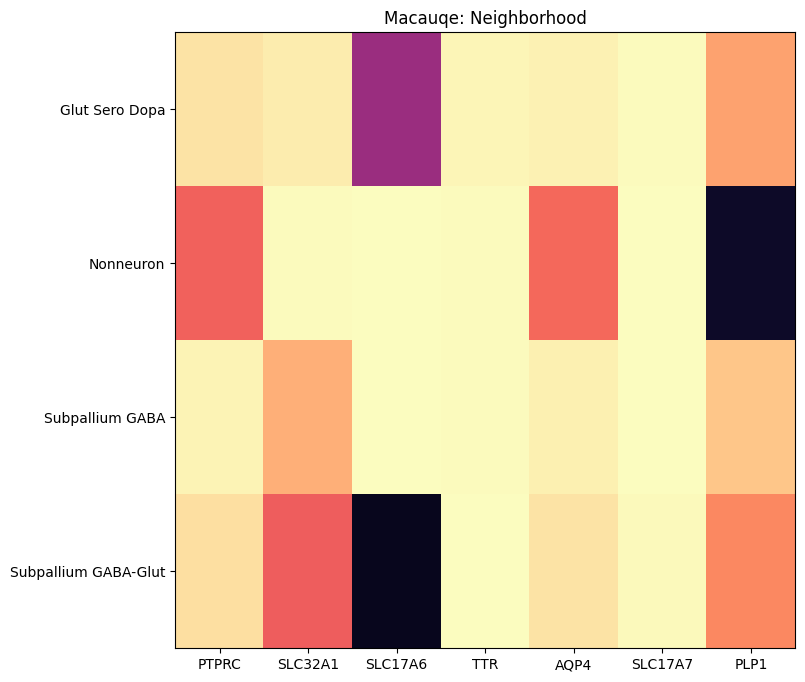

In [19]:
agg = aggregate_by_metadata(macaque_cells, gene_data.columns, 'Neighborhood')
fig, ax = plot_heatmap(agg, 8, 8)
ax.set_title('Macauqe: Neighborhood')
plt.show()

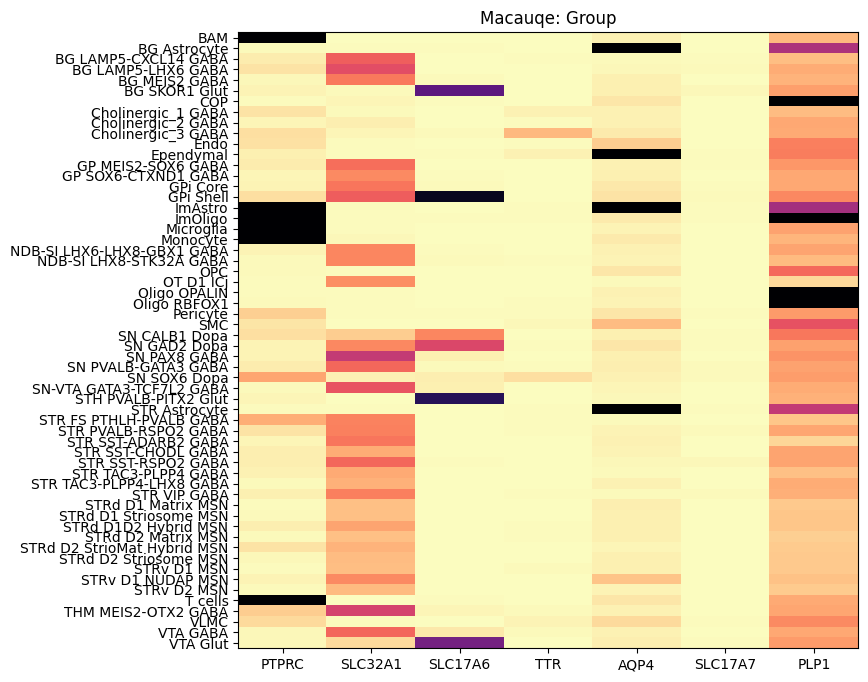

In [21]:
agg = aggregate_by_metadata(macaque_cells, gene_data.columns, 'Group')
fig, ax = plot_heatmap(agg, 8, 8)
ax.set_title('Macauqe: Group')
plt.show()

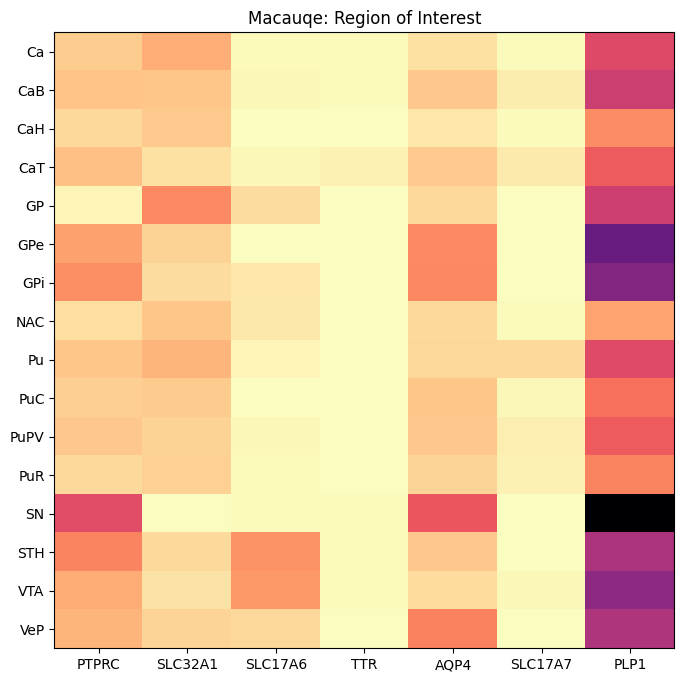

In [20]:
agg = aggregate_by_metadata(macaque_cells, gene_data.columns, 'region_of_interest_label')
fig, ax = plot_heatmap(agg, 8, 8)
ax.set_title('Macauqe: Region of Interest')
plt.show()

### Expression of selected genes in the Macaque Basial Ganglia

Below we plot heatmaps for the macaque gene expression versus various  

In [23]:
marmoset_cells = cell_extended_with_genes[cell_extended_with_genes['feature_matrix_label'] == 'HMBA-10xMultiome-BG-Marmoset']

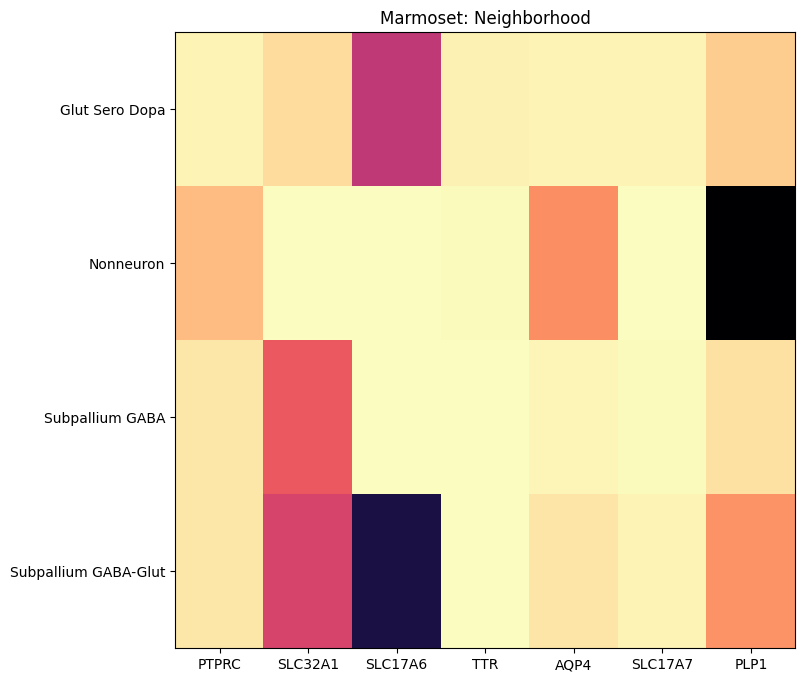

In [24]:
agg = aggregate_by_metadata(marmoset_cells, gene_data.columns, 'Neighborhood')
fig, ax = plot_heatmap(agg, 8, 8)
ax.set_title('Marmoset: Neighborhood')
plt.show()

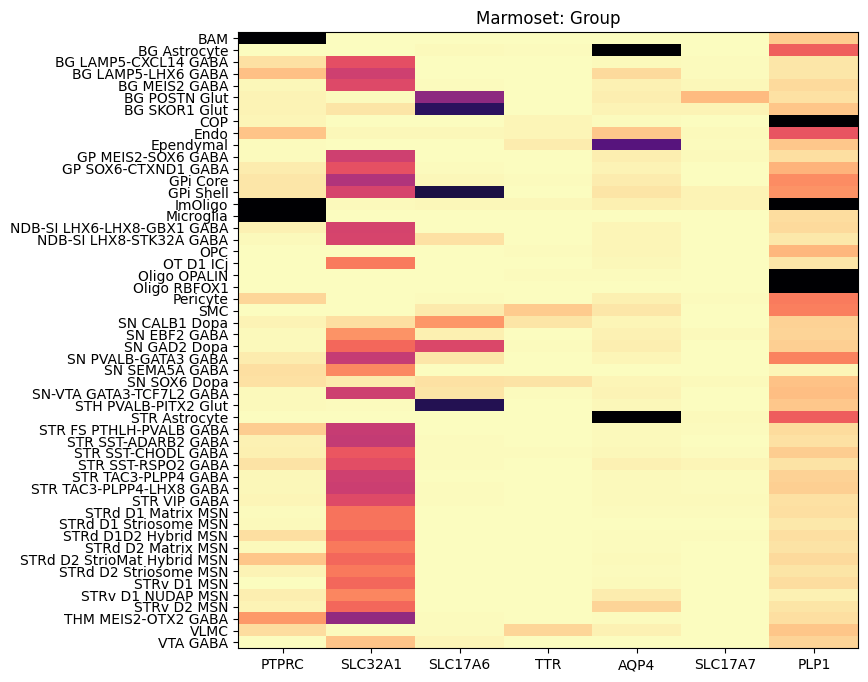

In [25]:
agg = aggregate_by_metadata(marmoset_cells, gene_data.columns, 'Group')
fig, ax = plot_heatmap(agg, 8, 8)
ax.set_title('Marmoset: Group')
plt.show()

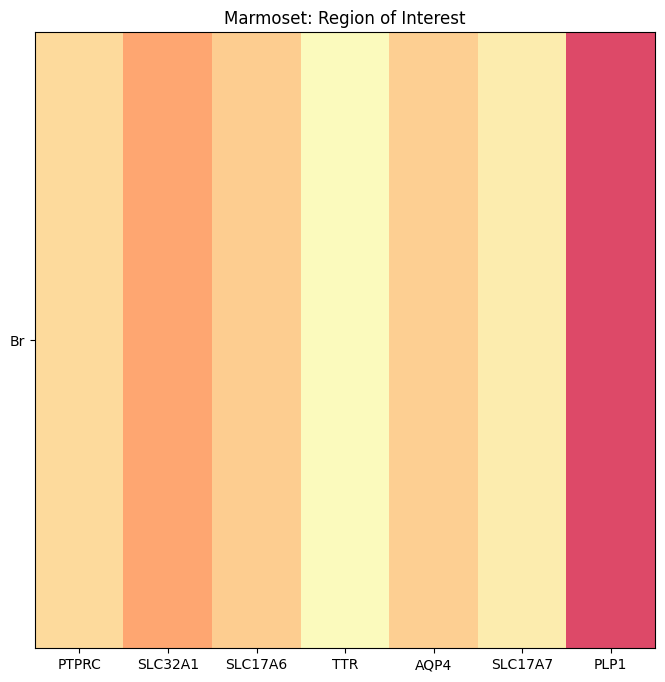

In [26]:
agg = aggregate_by_metadata(marmoset_cells, gene_data.columns, 'region_of_interest_label')
fig, ax = plot_heatmap(agg, 8, 8)
ax.set_title('Marmoset: Region of Interest')
plt.show()

### Expression of selected genes in the Human Basial Ganglia

Let's show the same visualizations for Human.

In [27]:
human_cells = cell_extended_with_genes[cell_extended_with_genes['feature_matrix_label'] == 'HMBA-10xMultiome-BG-Human']

Below, we plot the expression of the genes selected in seven genes. We show genes vs Neighborhood.

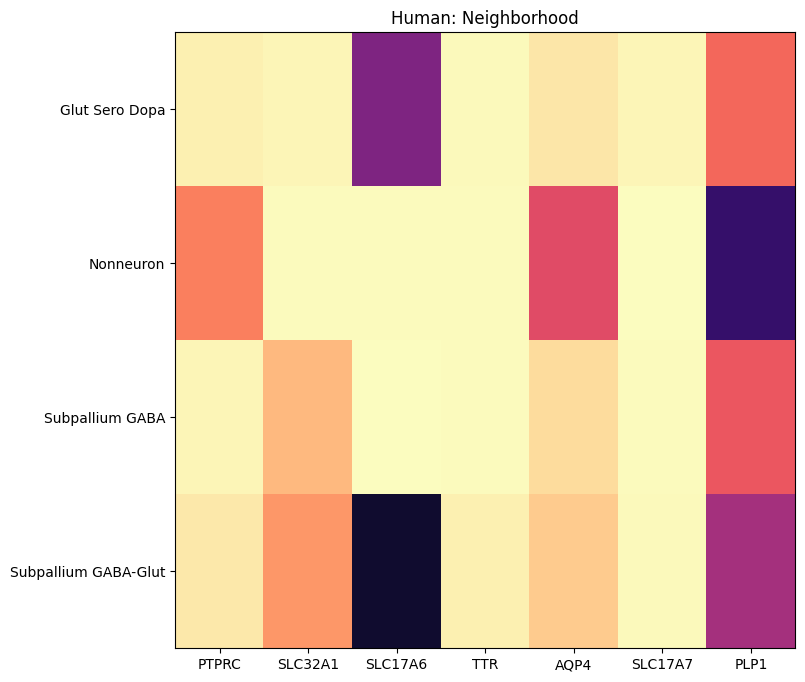

In [28]:
agg = aggregate_by_metadata(human_cells, gene_data.columns, 'Neighborhood')
fig, ax = plot_heatmap(agg, 8, 8)
ax.set_title('Human: Neighborhood')
plt.show()

Below is by dissection region of interest shows that each of these genes are associated with distinct brain regions.

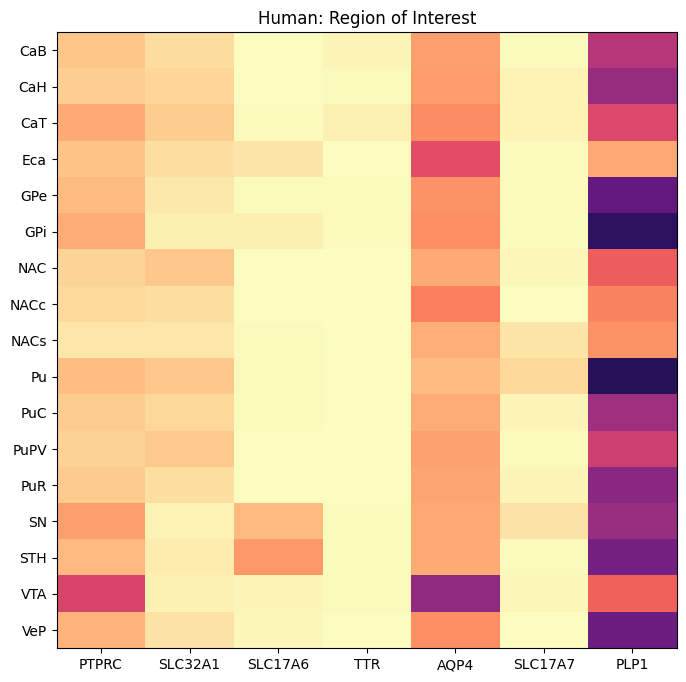

In [29]:
agg = aggregate_by_metadata(human_cells, gene_data.columns, 'region_of_interest_label')
fig, ax = plot_heatmap(agg, 8, 8)
ax.set_title('Human: Region of Interest')
plt.show()

And finally, by Group from the taxonomy.

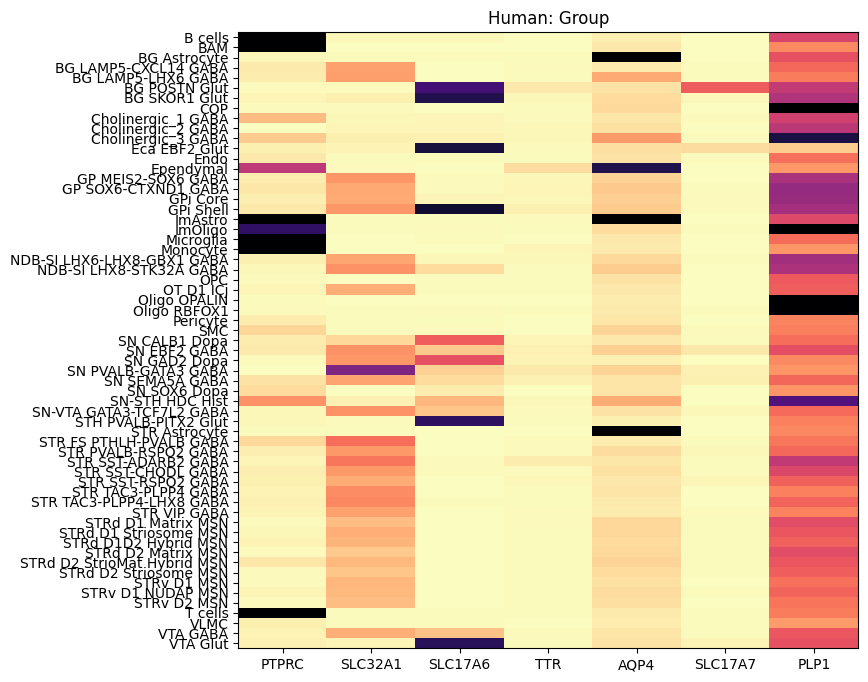

In [30]:
agg = aggregate_by_metadata(
    human_cells, gene_data.columns, 'Group')
fig, ax = plot_heatmap(agg, 8, 8)
ax.set_title('Human: Group')
plt.show()

## Expression in the UMAP

We can also visualize the relationship between these genes and their location in the UMAP. We'll plot the two species side by side with the grey cells in each plot representing those from the other species that do not overlap with the plotted one. Overall the expressions between species agree across the UMAP.

In [33]:
def plot_umap(df, feature, species_list, cmap=None, fig_width=21, fig_height=10) :
    
    fig, ax = plt.subplots(1, len(species_list))
    fig.set_size_inches(fig_width, fig_height)

    all_xx = df['x']
    all_yy = df['y']
    
    for idx, species in enumerate(species_list):
        
        filtered = df[df['species_common_name'] == species]
        xx = filtered['x']
        yy = filtered['y']
        vv = filtered[feature]

        ax[idx].scatter(all_xx, all_yy, s=1.0, color='#808080', marker='.')
        
        if cmap is not None :
            ax[idx].scatter(xx, yy, s=1.0, c=vv, marker='.', cmap=cmap)
        else :
            ax[idx].scatter(xx, yy, s=1.0, color=vv, marker=".")
            
        ax[idx].axis('equal')
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        
        ax[idx].set_title(f"{species}")
        
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    return fig, ax

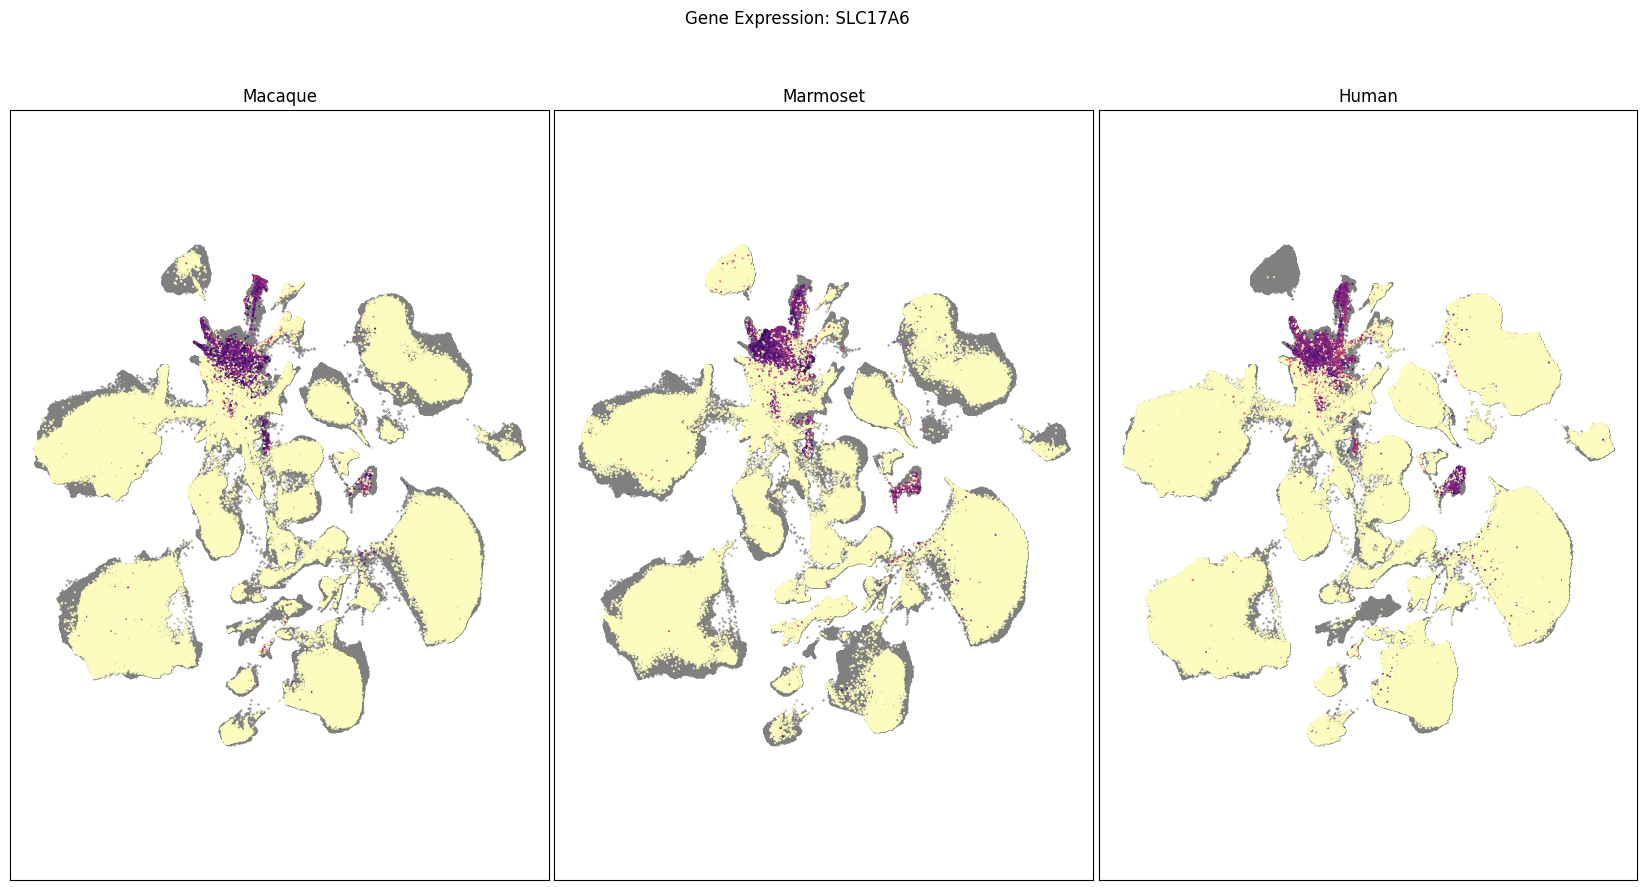

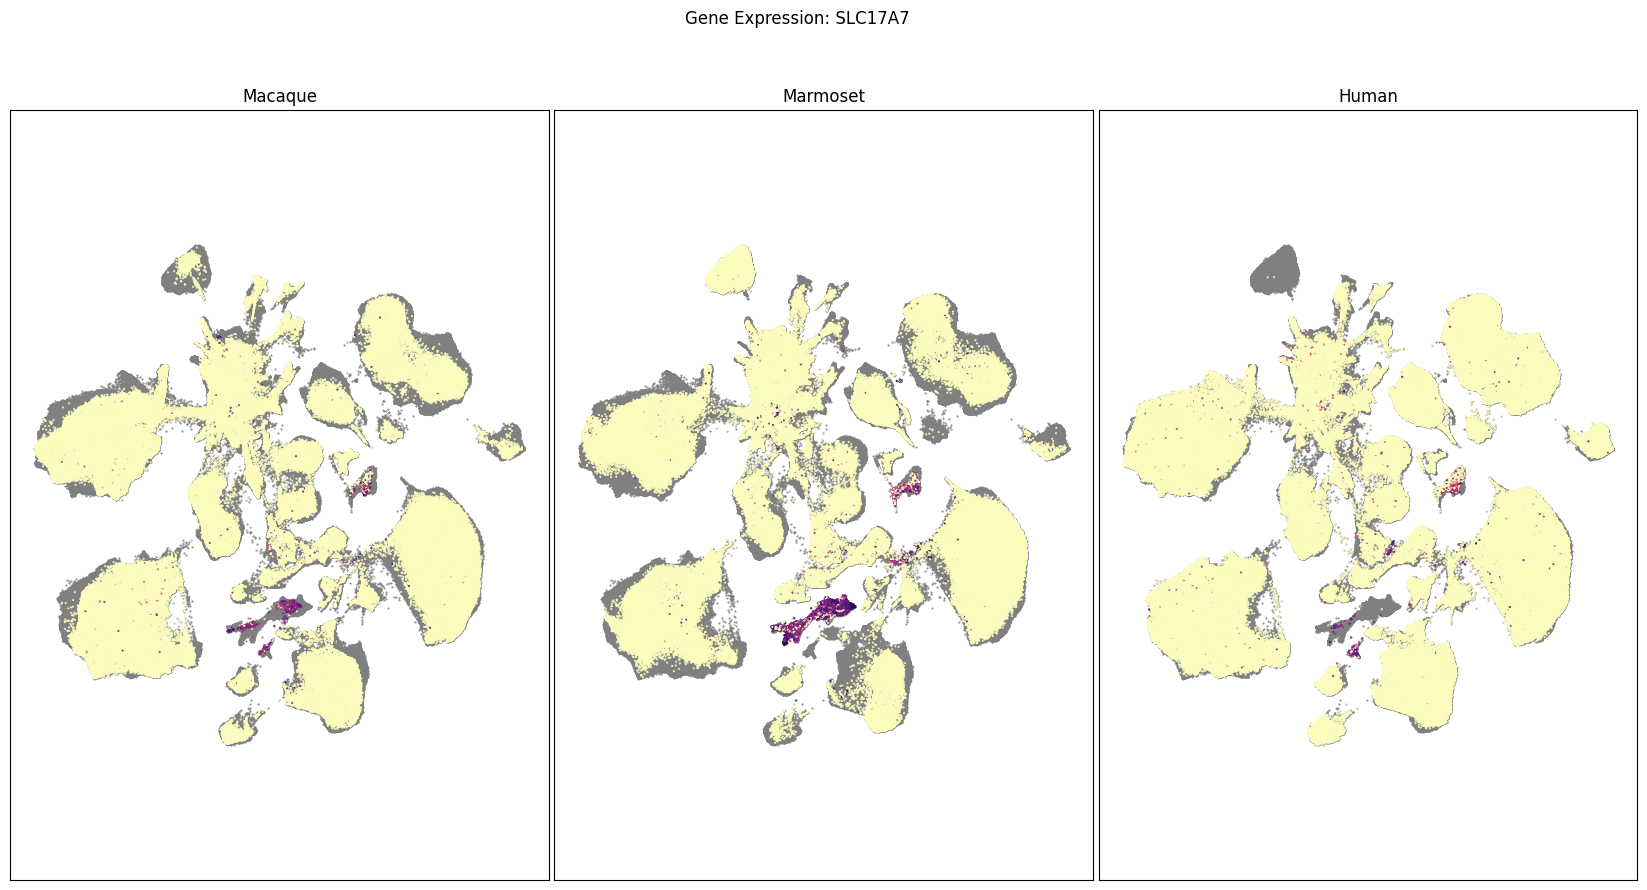

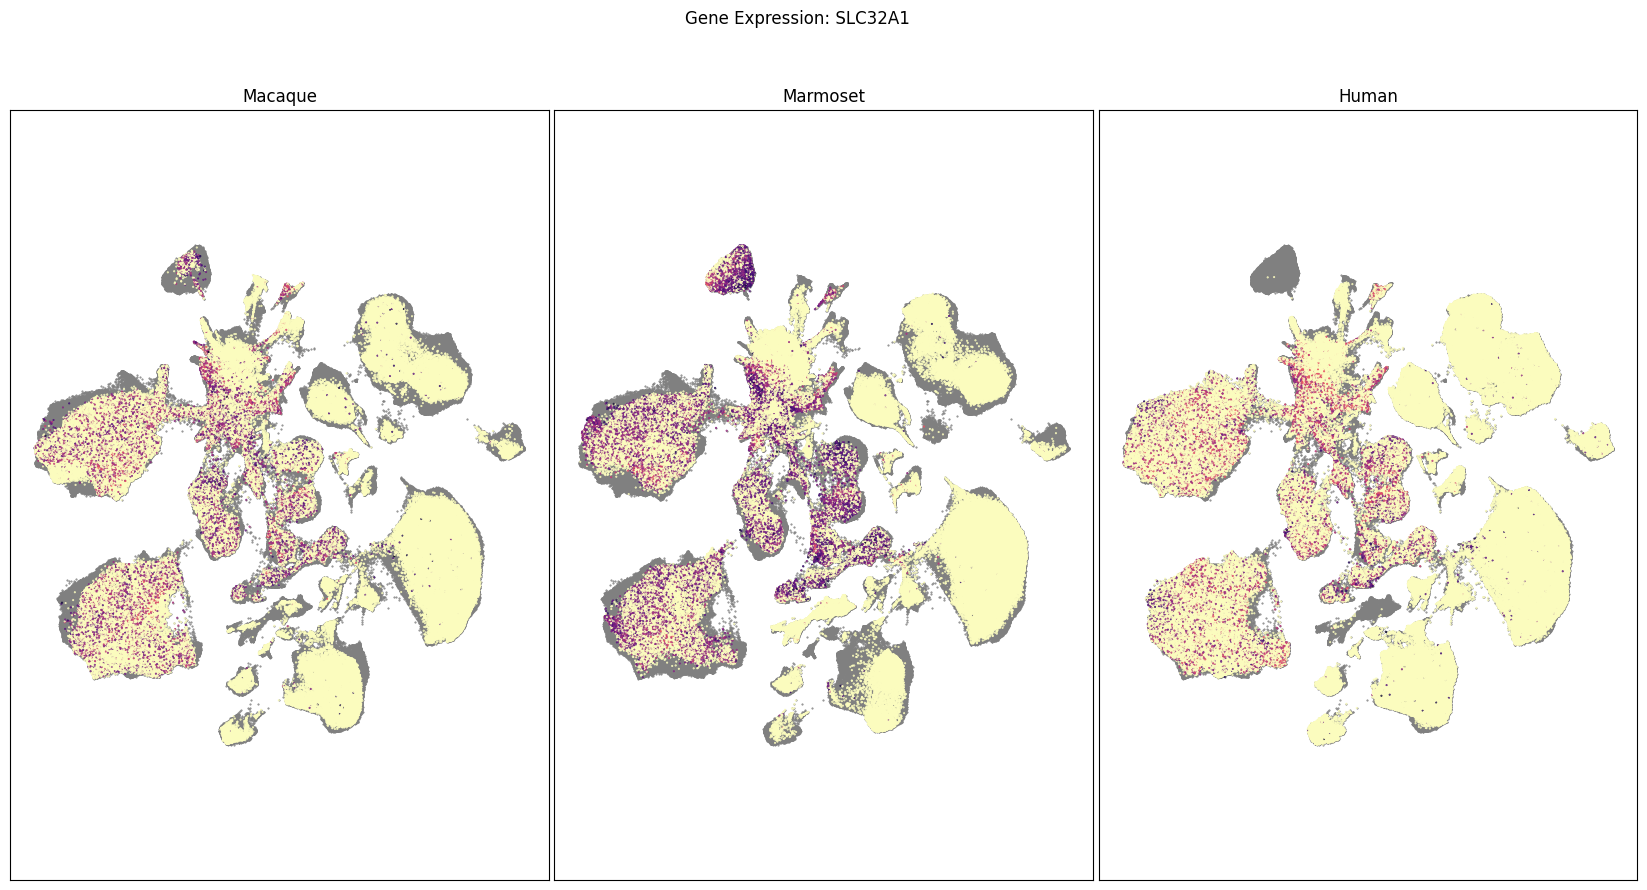

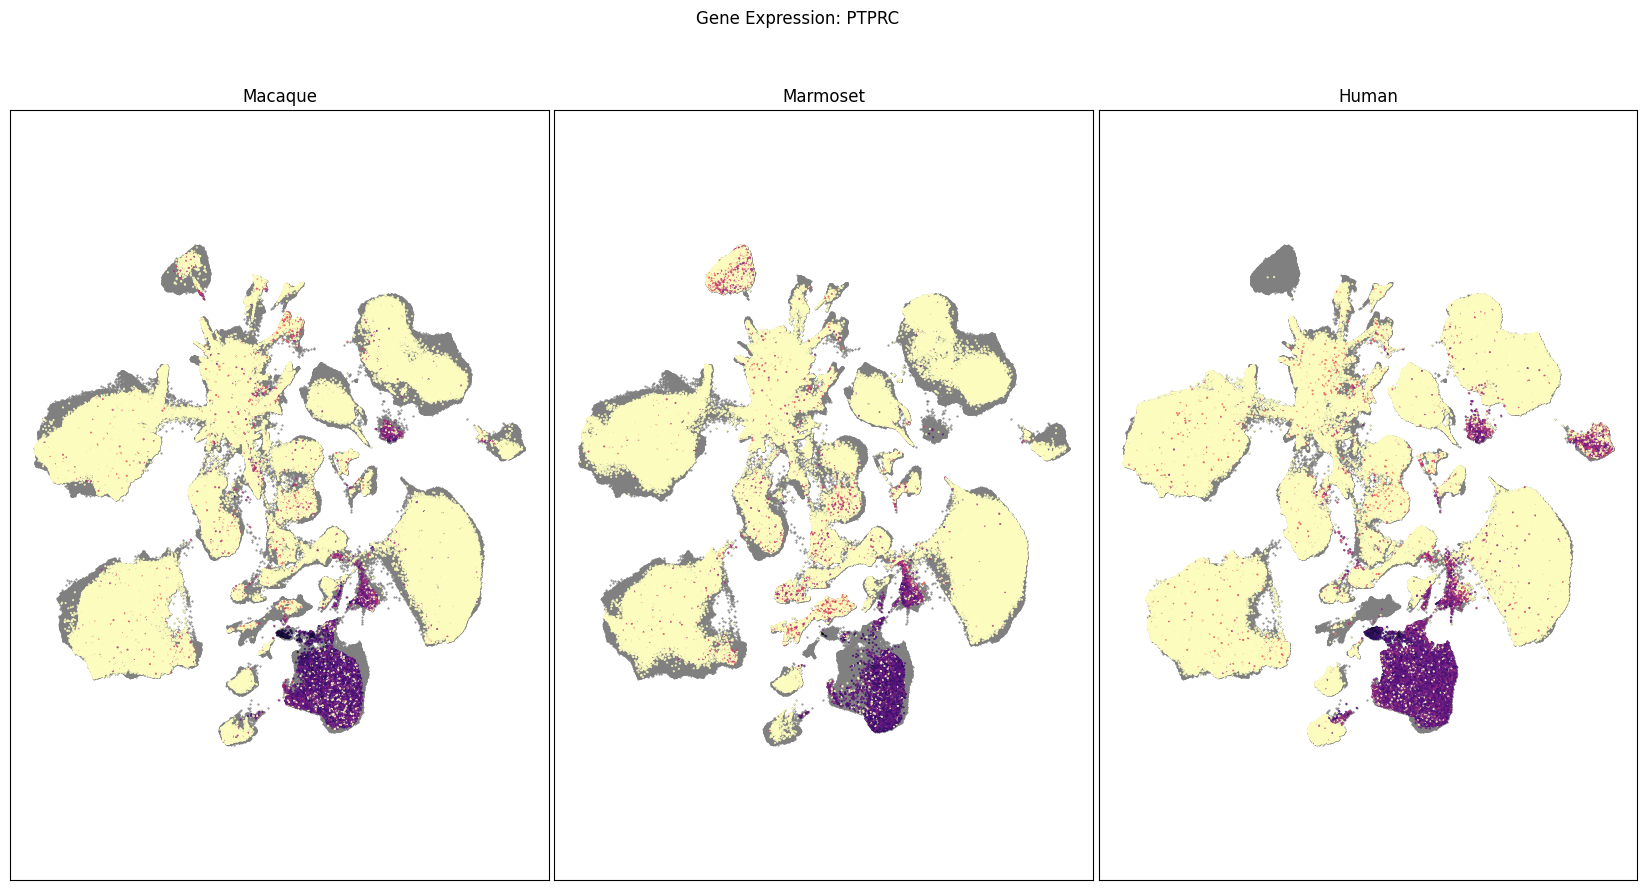

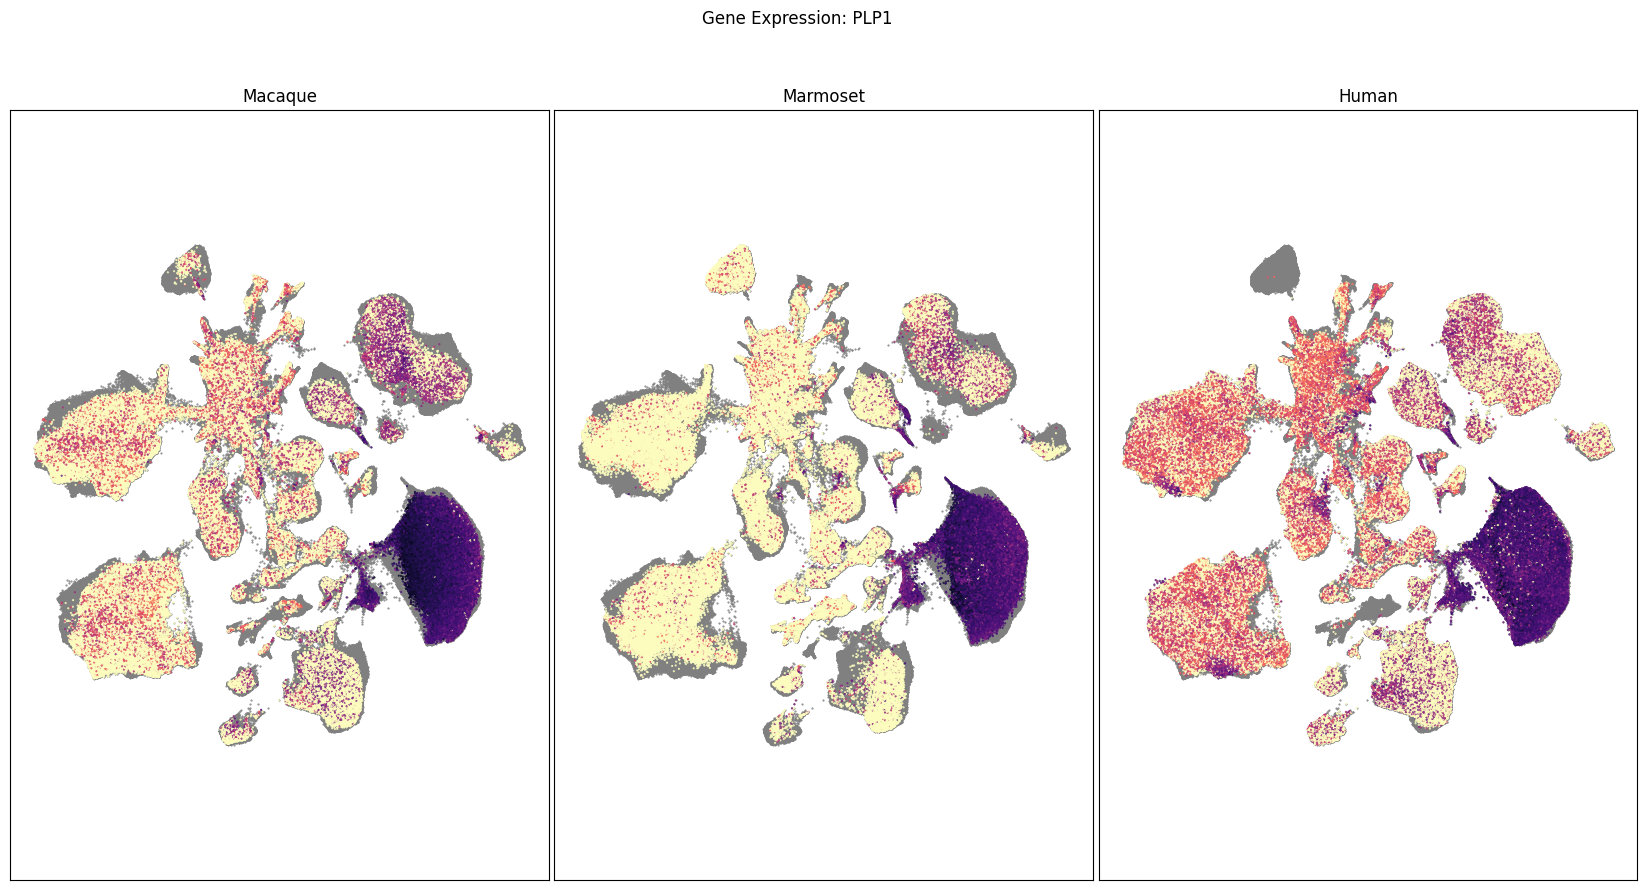

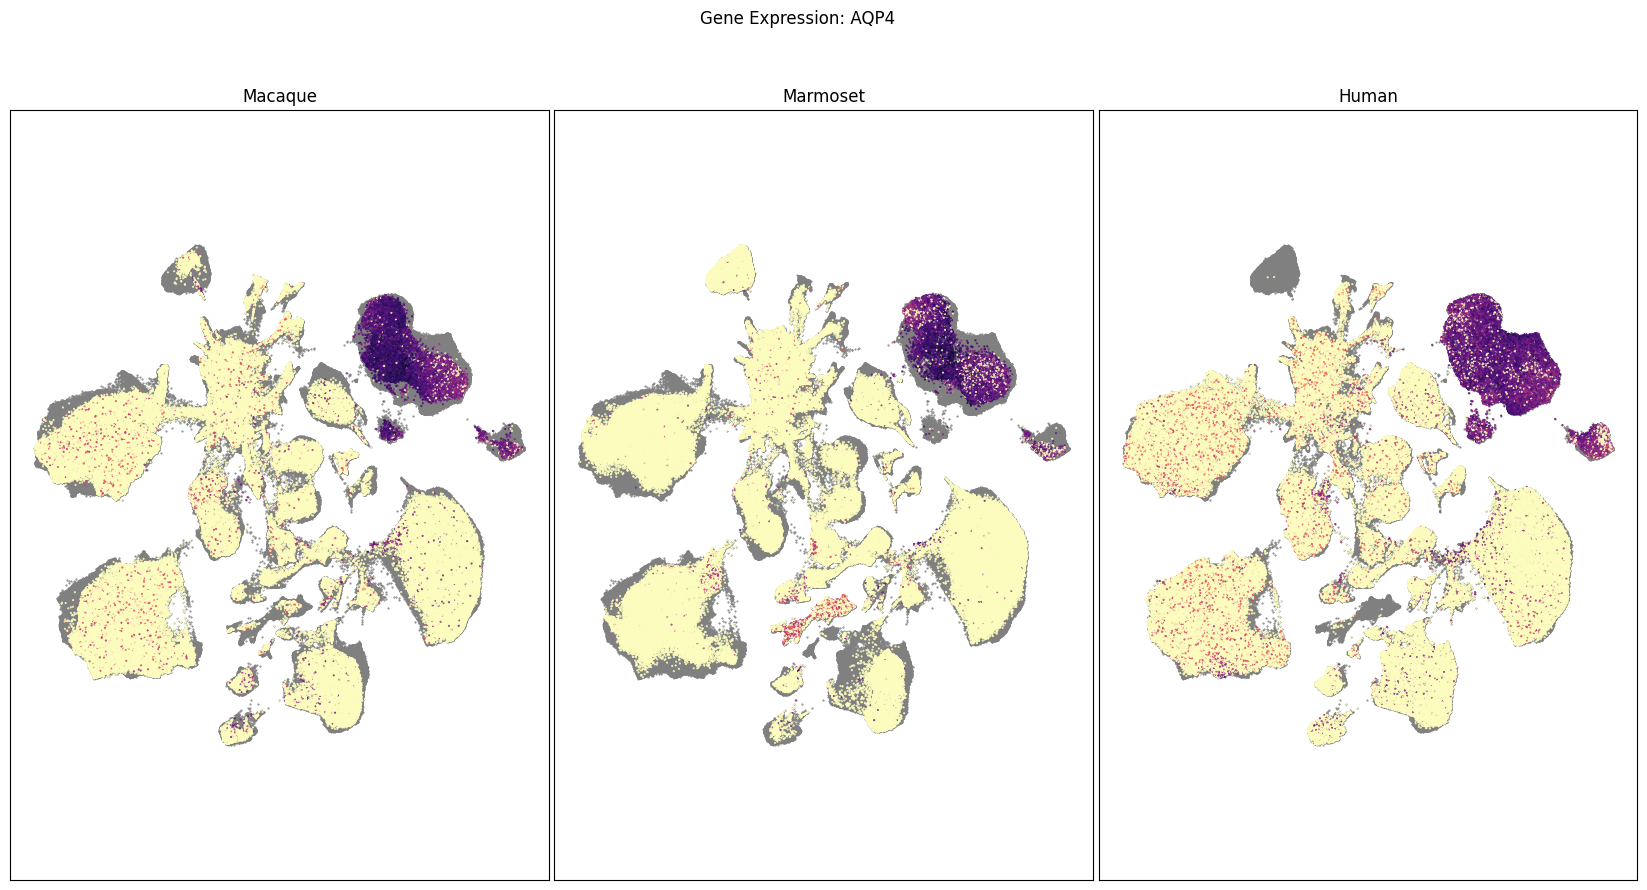

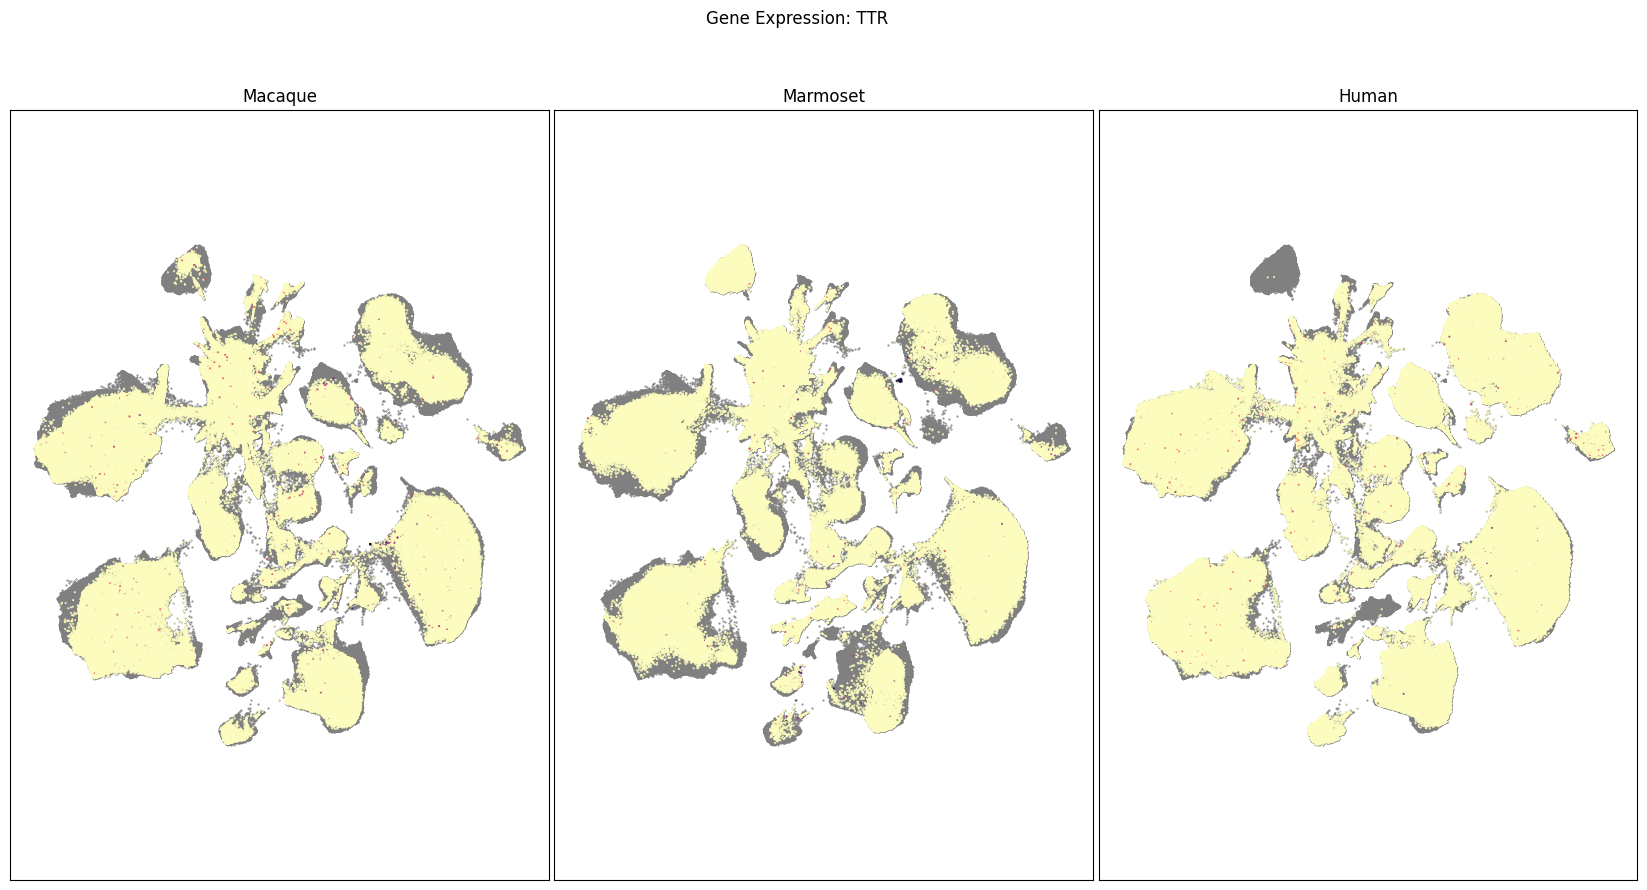

In [34]:
for gene_name in gene_names:
    fig, ax = plot_umap(
        cell_extended_with_genes,
        feature=gene_name,
        species_list=['Macaque', 'Marmoset', 'Human'],
        cmap=plt.cm.magma_r
    )
    fig.suptitle(f'Gene Expression: {gene_name}')
    plt.show()